In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dense, Flatten,
    Bidirectional, LSTM, GRU, Concatenate, Reshape, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset using the correct lowercase 'date' column
df = pd.read_csv('dataset.csv', parse_dates=['date'])

# Select the 'date' and 'sales' columns
df = df[['date', 'sales']]

# Rename columns to match the paper's convention ('Date', 'Sales')
df.rename(columns={'date': 'Date', 'sales': 'Sales'}, inplace=True)

# Set the new 'Date' column as the index
df.set_index('Date', inplace=True)

# 1. Create 'is_holiday' feature
bd_holidays = holidays.Bangladesh(years=range(2013, 2018))
df['is_holiday'] = df.index.isin(bd_holidays).astype(int)

# 2. Create Cyclic Features
df['month'] = df.index.month
df['day_of_month'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week
df['year'] = df.index.year

# Apply sin/cos transformations (Eqs. 1-8)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)
df['week_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)
df['year_sin'] = np.sin(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))
df['year_cos'] = np.cos(2 * np.pi * (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min()))

# 3. Final Feature Selection
features_df = df[['Sales', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
                  'week_sin', 'week_cos', 'year_sin', 'year_cos', 'is_holiday']]

print("Data shape after feature engineering:", features_df.shape)
print(features_df.head())

Data shape after feature engineering: (1826, 10)
            Sales  month_sin  month_cos   day_sin   day_cos  week_sin  \
Date                                                                    
2013-01-01     13        0.5   0.866025  0.201299  0.979530  0.120537   
2013-01-02     11        0.5   0.866025  0.394356  0.918958  0.120537   
2013-01-03     14        0.5   0.866025  0.571268  0.820763  0.120537   
2013-01-04     13        0.5   0.866025  0.724793  0.688967  0.120537   
2013-01-05     10        0.5   0.866025  0.848644  0.528964  0.120537   

            week_cos  year_sin  year_cos  is_holiday  
Date                                                  
2013-01-01  0.992709       0.0       1.0           0  
2013-01-02  0.992709       0.0       1.0           0  
2013-01-03  0.992709       0.0       1.0           0  
2013-01-04  0.992709       0.0       1.0           0  
2013-01-05  0.992709       0.0       1.0           0  


/tmp/ipython-input-2537554181.py:29: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(bd_holidays).astype(int)


In [17]:
# 1. Sequential Data Partitioning (70% train, 20% val, 10% test)
n = len(features_df)
train_df = features_df[0:int(n*0.7)]
val_df = features_df[int(n*0.7):int(n*0.9)]
test_df = features_df[int(n*0.9):]

print(f"\nTrain shape: {train_df.shape}")
print(f"Val shape:   {val_df.shape}")
print(f"Test shape:  {test_df.shape}")

# 2. Normalization
target_feature = 'Sales'
other_features = [col for col in features_df.columns if col not in [target_feature, 'is_holiday']]

# Initialize scalers
target_scaler = StandardScaler()
feature_scaler = StandardScaler()

# Fit scalers ONLY on training data
target_scaler.fit(train_df[[target_feature]])
feature_scaler.fit(train_df[other_features])

# Function to scale data
def scale_data(df):
    scaled_df = df.copy()
    scaled_df[target_feature] = target_scaler.transform(df[[target_feature]])
    scaled_df[other_features] = feature_scaler.transform(df[other_features])
    return scaled_df

# Transform all datasets
train_scaled = scale_data(train_df)
val_scaled = scale_data(val_df)
test_scaled = scale_data(test_df)

print("\nScaled data example:")
print(train_scaled.head())


Train shape: (1278, 10)
Val shape:   (365, 10)
Test shape:  (183, 10)

Scaled data example:
               Sales  month_sin  month_cos   day_sin   day_cos  week_sin  \
Date                                                                       
2013-01-01 -0.920447   0.594479   1.260508  0.279770  1.424760   0.04202   
2013-01-02 -1.229886   0.594479   1.260508  0.550389  1.338292   0.04202   
2013-01-03 -0.765728   0.594479   1.260508  0.798377  1.198118   0.04202   
2013-01-04 -0.920447   0.594479   1.260508  1.013581  1.009977   0.04202   
2013-01-05 -1.384606   0.594479   1.260508  1.187191  0.781571   0.04202   

            week_cos  year_sin  year_cos  is_holiday  
Date                                                  
2013-01-01   1.40075 -0.222811  1.323135           0  
2013-01-02   1.40075 -0.222811  1.323135           0  
2013-01-03   1.40075 -0.222811  1.323135           0  
2013-01-04   1.40075 -0.222811  1.323135           0  
2013-01-05   1.40075 -0.222811  1.323135    

In [18]:
# Define window parameters
INPUT_WIDTH = 30  # Input sequence length
LABEL_WIDTH = 30  # Output sequence length
SHIFT = 30        # For a single-shot, non-overlapping prediction
LABEL_COLUMNS = [target_feature] # We only predict sales

# Function to create windowed data
def create_windows(data, input_width, label_width, shift):
    X, y = [], []

    for i in range(0, len(data) - input_width - shift + 1):
        input_slice = data.iloc[i : i + input_width].values
        label_slice = data.iloc[i + input_width : i + input_width + shift][LABEL_COLUMNS].values

        # Ensure we have full-length labels
        if len(label_slice) == label_width:
            X.append(input_slice)
            y.append(label_slice)

    return np.array(X), np.array(y)

# Create windowed datasets
X_train, y_train = create_windows(train_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)
X_val, y_val = create_windows(val_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)
X_test, y_test = create_windows(test_scaled, INPUT_WIDTH, LABEL_WIDTH, SHIFT)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

# Create tf.data.Dataset for efficient training
BATCH_SIZE = 32 #

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


X_train shape: (1219, 30, 10)
y_train shape: (1219, 30, 1)
X_val shape:   (306, 30, 10)
y_val shape:   (306, 30, 1)
X_test shape:  (124, 30, 10)
y_test shape:  (124, 30, 1)


In [19]:
def build_mcdfn_model(input_shape=(INPUT_WIDTH, X_train.shape[2])):
    # Input Layer
    input_tensor = Input(shape=input_shape, name='Input_Layer') #

    # --- Branch 1: CNN ---
    #
    x1 = Conv1D(filters=352, kernel_size=1, activation='relu', name='CNN_Conv1_1')(input_tensor)
    x1 = Conv1D(filters=352, kernel_size=1, activation='relu', name='CNN_Conv1_2')(x1)
    x1 = MaxPooling1D(pool_size=3, name='CNN_MaxPool')(x1) # Inferred from Fig. 8 shape
    x1 = Dense(128, name='CNN_Dense')(x1)
    x1_flat = Flatten(name='CNN_Flatten')(x1)

    # --- Branch 2: BiLSTM ---
    #
    x2 = Bidirectional(LSTM(units=192, name='BiLSTM_Layer'), name='BiLSTM_Bidir')(input_tensor)
    x2_flat = Flatten(name='BiLSTM_Flatten')(x2)

    # --- Branch 3: Bi-GRU ---
    #
    x3 = Bidirectional(GRU(units=64, name='BiGRU_Layer'), name='BiGRU_Bidir')(input_tensor)
    x3_flat = Flatten(name='BiGRU_Flatten')(x3)

    # --- Branch 4: Stacked LSTM ---
    #
    x4 = LSTM(units=64, return_sequences=True, name='Stacked_LSTM_1')(input_tensor)
    x4 = Dropout(0.2, name='Stacked_Dropout_1')(x4)
    x4 = LSTM(units=64, name='Stacked_LSTM_2')(x4)
    x4 = Dropout(0.2, name='Stacked_Dropout_2')(x4)
    x4_flat = Flatten(name='Stacked_Flatten')(x4)

    # --- Fusion ---
    #
    fused = Concatenate(name='Fusion_Layer')([x1_flat, x2_flat, x3_flat, x4_flat])

    # --- Output Head ---
    #
    output = Dense(LABEL_WIDTH, activation='linear', name='Output_Dense')(fused)
    output = Reshape((LABEL_WIDTH, 1), name='Output_Reshape')(output)

    model = Model(inputs=input_tensor, outputs=output, name='MCDFN_Model')
    return model

# Build and summarize the model
mcdfn_model = build_mcdfn_model()
mcdfn_model.summary()

Model: "MCDFN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Conv1_1         │ (None, 30, 352)   │      3,872 │ Input_Layer[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_LSTM_1      │ (None, 30, 64)    │     19,200 │ Input_Layer[0][0] │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Conv1_2         │ (None, 30, 352)   │    124,256 │ CNN_Conv1_1[0][0] │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Dropout_1   │ (None, 30, 64)    │          0 │ Stacked_LSTM_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_MaxPool         │ (None, 10, 352)   │          0 │ CNN_Conv1_2[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_LSTM_2      │ (None, 64)        │     33,024 │ Stacked_Dropout_… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Dense (Dense)   │ (None, 10, 128)   │     45,184 │ CNN_MaxPool[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Bidir        │ (None, 384)       │    311,808 │ Input_Layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_Bidir         │ (None, 128)       │     29,184 │ Input_Layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Dropout_2   │ (None, 64)        │          0 │ Stacked_LSTM_2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CNN_Flatten         │ (None, 1280)      │          0 │ CNN_Dense[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiLSTM_Flatten      │ (None, 384)       │          0 │ BiLSTM_Bidir[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BiGRU_Flatten       │ (None, 128)       │          0 │ BiGRU_Bidir[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Stacked_Flatten     │ (None, 64)        │          0 │ Stacked_Dropout_… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fusion_Layer        │ (None, 1856)      │          0 │ CNN_Flatten[0][0… │
│ (Concatenate)       │                   │            │ BiLSTM_Flatten[0… │
│                     │                   │            │ BiGRU_Flatten[0]… │
│                     │                   │            │ Stacked_Flatten[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 622,238 (2.37 MB)

 Trainable params: 622,238 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
mcdfn_model.compile(optimizer='adam', #
                    loss='mse')       #

# Define EarlyStopping callback (CORRECTED LINE)
early_stopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              restore_best_weights=True) # Was 'restore__weights'

# Train the model
history = mcdfn_model.fit(
    train_dataset,
    epochs=50, #
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Save the model in the .keras format
mcdfn_model.save('mcdfn_model.keras')
print("\nModel saved as 'mcdfn_model.keras'.")

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.7608 - val_loss: 0.9695
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7695 - val_loss: 1.0128
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7081 - val_loss: 1.2474
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6030 - val_loss: 0.6938
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6235 - val_loss: 0.9576
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5833 - val_loss: 0.8349
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5833 - val_loss: 0.7464
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5654 - val_loss: 0.7617
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.5477 - val_loss: 0.7975
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5209 - val_loss: 0.7048
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5589 - val_loss: 0.7775
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5

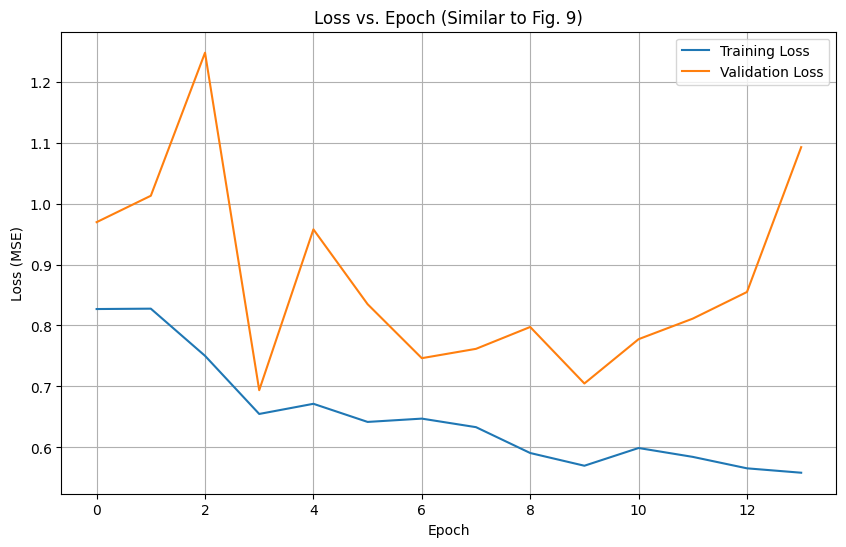

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
--- Test Set Evaluation Metrics ---
Test MSE:   34.2788
Test RMSE:  5.8548
Test MAE:   4.5936
Test MAPE:  22.58%


In [22]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epoch (Similar to Fig. 9)') #
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Get predictions on the test set
predictions_scaled = mcdfn_model.predict(test_dataset)

# Reshape for inverse scaling
pred_shape = predictions_scaled.shape
true_shape = y_test.shape
predictions_scaled_flat = predictions_scaled.reshape(pred_shape[0] * pred_shape[1], 1)
y_test_flat = y_test.reshape(true_shape[0] * true_shape[1], 1)

# Inverse transform to original sales values
predictions_unscaled = target_scaler.inverse_transform(predictions_scaled_flat)
y_test_unscaled = target_scaler.inverse_transform(y_test_flat)

# Calculate final metrics
mse = mean_squared_error(y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions_unscaled)
mape = mean_absolute_percentage_error(y_test_unscaled, predictions_unscaled)

print("--- Test Set Evaluation Metrics ---")
print(f"Test MSE:   {mse:.4f}")
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test MAE:   {mae:.4f}")
print(f"Test MAPE:  {mape*100:.2f}%")

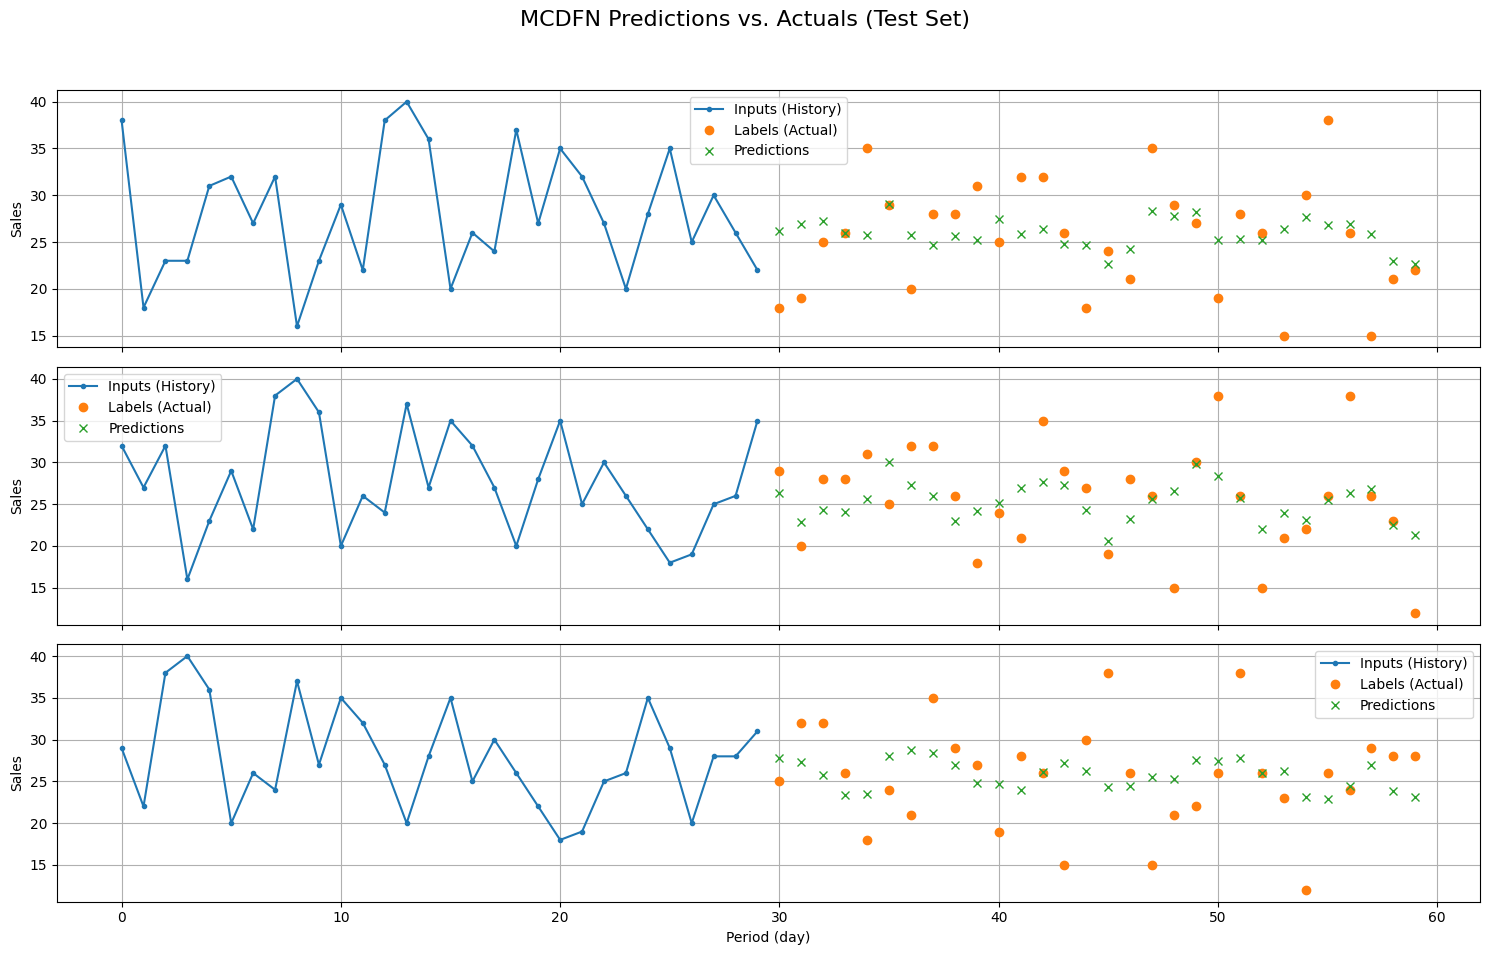

In [23]:
# Reshape predictions back to (windows, 30, 1) for easier plotting
predictions_unscaled_windows = predictions_unscaled.reshape(pred_shape)
y_test_unscaled_windows = y_test_unscaled.reshape(true_shape)
X_test_sales_unscaled = target_scaler.inverse_transform(X_test[:, :, 0])

# Plot 3 example windows
plot_indices = [0, 5, 10]
fig, axes = plt.subplots(len(plot_indices), 1, figsize=(15, 10), sharex=True)
fig.suptitle('MCDFN Predictions vs. Actuals (Test Set)', fontsize=16)

for i, idx in enumerate(plot_indices):
    if idx >= len(X_test_sales_unscaled):
        continue
    ax = axes[i]
    input_days = np.arange(0, INPUT_WIDTH)
    ax.plot(input_days, X_test_sales_unscaled[idx, :], label='Inputs (History)', marker='.')
    label_days = np.arange(INPUT_WIDTH, INPUT_WIDTH + LABEL_WIDTH)
    ax.plot(label_days, y_test_unscaled_windows[idx, :, 0], label='Labels (Actual)', marker='o', linestyle='None')
    ax.plot(label_days, predictions_unscaled_windows[idx, :, 0], label='Predictions', marker='x', linestyle='None')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Period (day)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Predicting using data from 2016-07-02 00:00:00 to 2016-07-31 00:00:00 ---


/tmp/ipython-input-2134218662.py:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_slice['is_holiday'] = df_slice.index.isin(bd_holidays).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

--- 30-Day Sales Forecast ---
[27.89 27.69 27.35 28.48 28.54 31.94 29.87 26.77 25.88 26.8  27.31 30.2
 29.77 29.56 27.72 25.32 25.98 28.78 30.15 32.14 30.33 28.65 26.08 27.48
 28.74 29.13 30.14 30.51 26.79 25.49]

--- Comparison ---


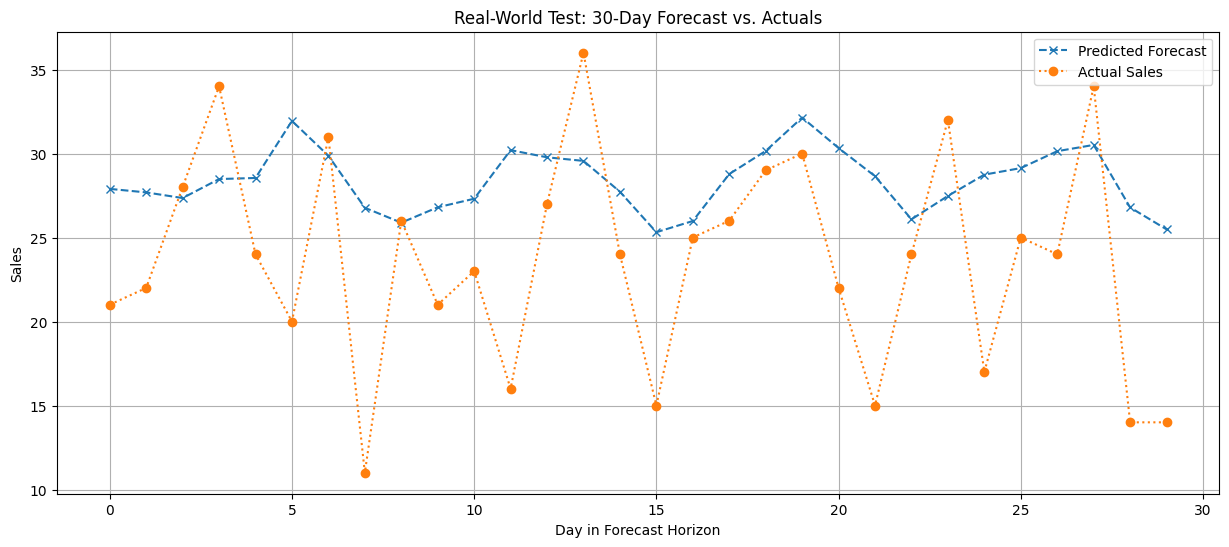

In [24]:
# --- 1. Load the saved model ---
# from tensorflow.keras.models import load_model
# model = load_model('mcdfn_model.keras')
# NOTE: We can just use 'mcdfn_model' since it's already in memory

# --- 2. Get 30 days of raw data ---
# We'll take the first 30 days of the validation set as an example
start_idx = int(n * 0.7) # Start of validation set
end_idx = start_idx + INPUT_WIDTH # Get 30 days
raw_input_data = pd.read_csv('dataset.csv', parse_dates=['date']).iloc[start_idx:end_idx]

# We also get the *actual* next 30 days to compare our forecast
actual_next_30_days = pd.read_csv('dataset.csv').iloc[end_idx : end_idx + LABEL_WIDTH]

print(f"--- Predicting using data from {raw_input_data['date'].min()} to {raw_input_data['date'].max()} ---")

# --- 3. Preprocess the raw data ---
# This function MUST be identical to the preprocessing in Step 1
def preprocess_new_data(df_slice):
    df_slice = df_slice.copy()
    df_slice.set_index('date', inplace=True)
    df_slice['is_holiday'] = df_slice.index.isin(bd_holidays).astype(int)
    df_slice['month'] = df_slice.index.month
    df_slice['day_of_month'] = df_slice.index.day
    df_slice['week_of_year'] = df_slice.index.isocalendar().week
    df_slice['year'] = df_slice.index.year
    df_slice['month_sin'] = np.sin(2 * np.pi * df_slice['month'] / 12)
    df_slice['month_cos'] = np.cos(2 * np.pi * df_slice['month'] / 12)
    df_slice['day_sin'] = np.sin(2 * np.pi * df_slice['day_of_month'] / 31)
    df_slice['day_cos'] = np.cos(2 * np.pi * df_slice['day_of_month'] / 31)
    df_slice['week_sin'] = np.sin(2 * np.pi * df_slice['week_of_year'] / 52)
    df_slice['week_cos'] = np.cos(2 * np.pi * df_slice['week_of_year'] / 52)
    df_slice['year_sin'] = np.sin(2 * np.pi * (df_slice['year'] - 2013) / (2017 - 2013)) # Use same range as training
    df_slice['year_cos'] = np.cos(2 * np.pi * (df_slice['year'] - 2013) / (2017 - 2013))
    # Rename 'sales' to 'Sales' and ensure correct column order
    df_slice.rename(columns={'sales': 'Sales'}, inplace=True)
    return df_slice[features_df.columns] # Return in the same order as training

processed_input = preprocess_new_data(raw_input_data)

# --- 4. Scale the data using *fitted* scalers ---
# DO NOT .fit() again, only .transform()
scaled_input = processed_input.copy()
scaled_input[target_feature] = target_scaler.transform(processed_input[[target_feature]])
scaled_input[other_features] = feature_scaler.transform(processed_input[other_features])

# --- 5. Reshape for the model ---
# Model expects (batch_size, timesteps, features)
model_input = np.array(scaled_input).reshape(1, INPUT_WIDTH, 10) # 1 sample, 30 days, 10 features

# --- 6. Predict ---
scaled_prediction = mcdfn_model.predict(model_input)

# --- 7. Inverse transform the prediction ---
# Reshape for scaler: (30, 1)
scaled_prediction_flat = scaled_prediction.reshape(LABEL_WIDTH, 1)
final_forecast = target_scaler.inverse_transform(scaled_prediction_flat)

# --- 8. View the results ---
print("\n--- 30-Day Sales Forecast ---")
print(final_forecast.flatten().round(2))

print("\n--- Comparison ---")
plt.figure(figsize=(15, 6))
plt.plot(np.arange(30), final_forecast, label='Predicted Forecast', marker='x', linestyle='--')
plt.plot(np.arange(30), actual_next_30_days['sales'].values, label='Actual Sales', marker='o', linestyle=':')
plt.title('Real-World Test: 30-Day Forecast vs. Actuals')
plt.xlabel('Day in Forecast Horizon')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()